In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install netCDF4

In [5]:
import os
import sys
DRIVE_ROOT = "/content/drive/MyDrive/DynamicsTensors"
REPO_ROOT  = f"{DRIVE_ROOT}/bstt2"
DATA_DIR   = f"{DRIVE_ROOT}/data"
OUT_DIR    = f"{DRIVE_ROOT}/outputs"

EXP = "basetests"
RUN_DIR = f"{OUT_DIR}/{EXP}"

os.makedirs(RUN_DIR, exist_ok=True)
if REPO_ROOT not in sys.path: sys.path.append(REPO_ROOT)

print("Repo:", REPO_ROOT)
print("Data:", DATA_DIR)
print("Run dir:", RUN_DIR)
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")

from utils import name_scan, inspect_fields, load_fields, Dataset, chartostring, plot_flow_snapshot, plot_heatmap_contours

Repo: /content/drive/MyDrive/DynamicsTensors/bstt2
Data: /content/drive/MyDrive/DynamicsTensors/data
Run dir: /content/drive/MyDrive/DynamicsTensors/outputs/basetests


In [8]:
# Uploading orginal bsst modules
from misc import  __block, sinecosine_measures, random_homogenous_polynomial_sum_system2,random_fixed_variable_sum_system2,legendre_measures
from helpers import fermi_pasta_ulam,fermi_pasta_ulam2,SMat
from als import ALSSystem2
from bstt import Block, BlockSparseTensor, BlockSparseTT
block = __block()
######################
# Import Standard libs
from time import time as clock
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.tri as mtri
from utils import name_scan, inspect_fields, load_fields, Dataset, chartostring, plot_flow_snapshot, plot_heatmap_contours


In [7]:
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")
print("format:", name_scan(train_path))
###################################################
meta = inspect_fields(train_path)
print(meta)
times, coordx, coordy, Vx, Vy, P, V_stack = load_fields(train_path, t_start=0, t_count=None)
print("shape times:", times.shape)
print("shape coords:", coordx.shape, coordy.shape)
print("shape Vx/Vy/P:", Vx.shape, Vy.shape, P.shape)
print("shape V_stack:", V_stack.shape)

format: exodus
{'format': 'exodus', 'num_nodes': 6569, 'num_elems': 6384, 'time_steps': 5541, 'nodal_var_names': ['V_y', 'V_x', 'P'], 'time_key_guess': 'time_whole'}
shape times: (5541,)
shape coords: (6569,) (6569,)
shape Vx/Vy/P: (6569, 5541) (6569, 5541) (6569, 5541)
shape V_stack: (13138, 5541)


In [18]:
# Velocities vector fields extracted, data is stucked in V = [Vx,Vy,T].
# Culculating difference ( extremely simple)
dV_stuck = np.diff(V_stack, axis = 1)
dV_stuck.shape

(13138, 5540)

In [15]:
def plot_vector_field(Fx,Fy, path, t_index=0, quiver_frac=0.03, probe_node=None):
    ds = Dataset(path, "r")
    x = ds.variables["coordx"][:]
    y = ds.variables["coordy"][:]

    conn_keys = [k for k in ds.variables.keys() if k.startswith("connect")]
    assert conn_keys, "No connectivity array ('connect*') found."
    conn = np.asarray(ds.variables[conn_keys[0]][:], dtype=int) - 1
    if conn.shape[1] == 3:
        tri_conn = conn
    elif conn.shape[1] == 4:
        tri_conn = np.vstack([conn[:, [0, 1, 2]],
                              conn[:, [0, 2, 3]]])
    else:
        raise ValueError(f"Unsupported element with {conn.shape[1]} nodes (expected 3 or 4).")
    tri = mtri.Triangulation(x, y, triangles=tri_conn)

    # Snapshot
    Vy_t = Fy[:,t_index]
    Vx_t = Fx[:,t_index]
    magnitude = np.sqrt(Vx_t**2 + Vy_t**2)

    # Downsample for quiver
    n = x.size
    step = max(1, int(round(1.0 / max(quiver_frac, 1e-6))))
    q_idx = np.arange(0, n, step)

    # Figure: heatmap (|V|) + quiver
    fig, ax = plt.subplots(figsize=(15, 10))
    # Heatmap on unstructured mesh
    tpc = ax.tripcolor(tri, magnitude, shading="gouraud")
    cb = plt.colorbar(tpc, ax=ax, shrink=0.9, label="|V|")
    # Quiver on top
    ax.quiver(
        x[q_idx], y[q_idx], Vx_t[q_idx], Vy_t[q_idx],
        angles="xy", scale_units="xy", scale=1, width=0.002,
        alpha=0.9, zorder=3
    )
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"{os.path.basename(path)} | t={t_index}")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    fig.tight_layout()
    plt.show()

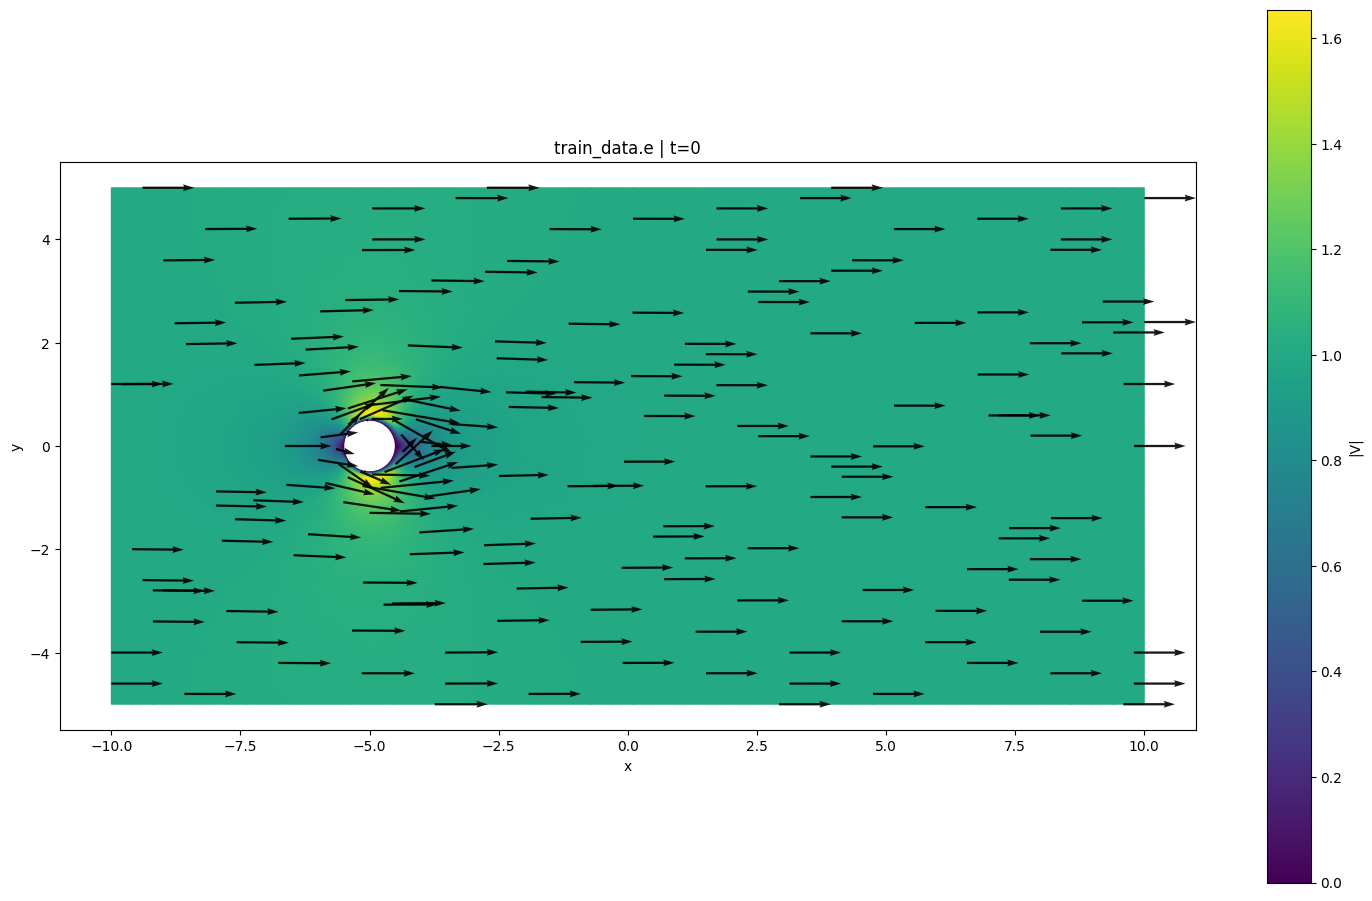

In [16]:
plot_vector_field(Vx,Vy,train_path)

### Testing FPUT: Fermi-Pasta-Ulam-Tsingou

In [ ]:
# CONFIGURATION:
order = 50  # Physical dimension in the paper
degree = 3  # [p0,p1,p2,p3] - degree of funciton from dictionary
maxGroupSize = 2
#interaction = [3]+ [4] + [5]*(order-4) + [4] + [3]
interaction = 5 # 2L + 3 --> nierest neighbors
#interaction = [2]*order
trainSampleSize = [200,800]
maxSweeps=10
ranks = [4]*(order-1)
targetResidual = 1e-6
trainSampleSizes =  [200,800]
testSampleSize = 20000
seed_global = 123
###############################################################################

In [ ]:
def make_fpu_params(order: int, seed: int):
    np.random.seed(seed)
    kappa = 2. * np.random.rand(order)
    beta  = 1.4 *np.random.rand(order)
    return kappa, beta

def make_dataset_FPUT(order: int, N: int, kappa: np.ndarray, beta: np.ndarray):
    """
    Generate N samples for the FPUT system.
    """
    points, values = fermi_pasta_ulam2(order, N, kappa, beta)
    return points, values

In [ ]:
# Checking
kappa, beta = make_fpu_params(order, 123)
X, Y = make_dataset_FPUT(order, 2000, kappa, beta)  # shapes (N, order)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (2000, 50), Y.shape: (2000, 50)


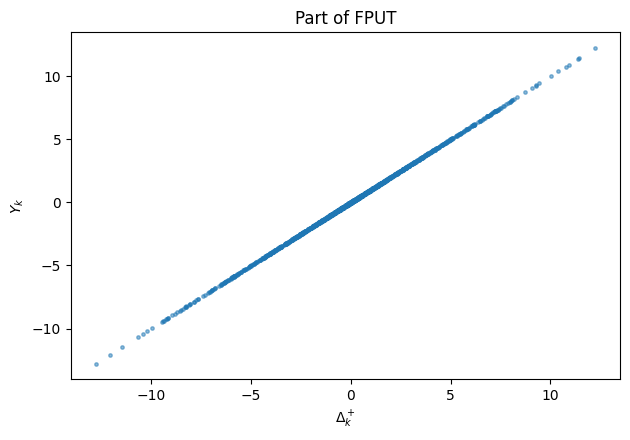

In [ ]:
# Sanity Check!
k = 12
d_plus = X[:, k + 1] - X[:, k]
d_minus = X[:, k] - X[:, k - 1]
# must be line! (se essentially this is random numbers that coonects one funciton to another!)
res = kappa[k+1] * d_plus - kappa[k] * d_minus + beta[k+1]* d_plus**3 - beta[k]*d_minus**3
plt.figure(figsize=(6.4, 4.5))
plt.scatter(res, Y[:, k] , s=6, alpha=0.5)
plt.xlabel(r"$\Delta^+_k$")
plt.ylabel(r"$Y_{k}$")
plt.title(f"Part of FPUT")
plt.tight_layout()
plt.show()

In [ ]:
def build_measures(points, degree, add_constant_mode=True):
    """
    Build Legendre dict values per coordinate and optionally append a constant mode.
    points: (N, order)
    Returns:
        measures: (order + add_constant, N, degree+1)
    """
    # legendre_measures expects shape (N, M) and returns (M, N, degree+1)
    measures = legendre_measures(points, degree)  # (order, N, degree+1)
    if add_constant_mode:
        ones_row = np.ones((1, points.shape[0], degree + 1))
        measures = np.concatenate([measures, ones_row], axis=0)  # (order+1, N, degree+1)
    return measures


In [ ]:
measures = build_measures(X, degree = degree)
measures.shape

(51, 2000, 4)

In [ ]:
def build_model(order, degree, maxGroupSize, interaction, selection_matrix=None):
    """
    Create a BlockSparseTTSystem2 model with degree-banded blocks and interaction gating.

    System2 expects an integer selection matrix of shape (D, order) where
    D = number of equations (=order here) and 'order' is the number of TT cores
    (we use order+1 measures; the extra constant mode is handled by the TT builder).
    We use helpers.SMat(interaction, order) to produce this gating.
    """
    S = selection_matrix if selection_matrix is not None else SMat(interaction, order)
    bstt = random_homogenous_polynomial_sum_system2(
        _univariateDegrees=[degree] * order,
        _totalDegree=degree,
        _maxGroupSize=maxGroupSize,
        _numberOfInteractions=interaction,
        _selectionMatrix=S,
    )
    return bstt

In [ ]:
def build_model(order, degree, maxGroupSize, interaction, selection_matrix=None):
    """
    Create a BlockSparseTTSystem2 model with degree-banded blocks and interaction gating.
    System2 expects an integer selection matrix of shape (D, order) where
    D = number of equations (=order here) and 'order' is the number of TT cores
    (we use order+1 measures; the extra constant mode is handled by the TT builder)
    """
    S = selection_matrix if selection_matrix is not None else SMat(interaction, order)
    bstt = random_homogenous_polynomial_sum_system2(
        _univariateDegrees=[degree] * order,
        _totalDegree=degree,
        _maxGroupSize=maxGroupSize,
        _numberOfInteractions=interaction,
        _selectionMatrix=S,
    )
    return bstt

def fit_model(bstt, measures, targets, maxSweeps, targetResidual, maxGroupSize, verbosity=1):
    """
    Wrap ALSSystem2
    """
    solver = ALSSystem2(bstt, measures, targets, _verbosity=verbosity)
    solver.maxSweeps = maxSweeps
    solver.targetResidual = targetResidual
    solver.maxGroupSize = maxGroupSize
    solver.run()
    return bstt, solver
# Evaluation
def rel_L2(pred, truth):
    """Relative L2 error"""
    return np.linalg.norm(pred - truth) / np.linalg.norm(truth)
def evaluate_model(bstt, measures_train, y_train, measures_test, y_test):
    """
    Evaluate on train & test measures/targets.
    Returns (err_train, err_test)
    """
    ytr_hat = bstt.evaluate(measures_train)
    yte_hat = bstt.evaluate(measures_test)
    return rel_L2(ytr_hat, y_train), rel_L2(yte_hat, y_test)
# ---------------------------
# Learning-curve driver
# ---------------------------
def run_learning_curve(
    order,
    degree,
    maxGroupSize,
    interaction,
    trainSampleSizes,
    testSampleSize,
    maxSweeps,
    targetResidual,
    seed=123,
    verbose=1,
):
    """
    Fix physics once, then sweep over training sample sizes to build a learning curve.
    Returns:
        results: list of dicts with metrics per sample size
    """
    # Fix system parameters once
    kappa, beta = make_fpu_params(order, seed=seed)

    results = []
    for N in trainSampleSizes:
        if verbose:
            print(f"\n=== Training with N={N} samples ===")

        # Data
        Xtr, Ytr = make_dataset_FPUT(order, N, kappa, beta)
        Xte, Yte = make_dataset_FPUT(order, testSampleSize, kappa, beta)

        # Measures
        Mtr = build_measures(Xtr, degree, add_constant_mode=True)
        Mte = build_measures(Xte, degree, add_constant_mode=True)

        # Model
        bstt = build_model(order, degree, maxGroupSize, interaction)

        if verbose:
            print(f"DOFS: {bstt.dofs()}")
            print(f"Ranks: {bstt.ranks}")
            print(f"Interaction: {bstt.interactions}")

        # Train
        bstt, solver = fit_model(
            bstt, Mtr, Ytr,
            maxSweeps=maxSweeps,
            targetResidual=targetResidual,
            maxGroupSize=maxGroupSize,
            verbosity=1 if verbose else 0,
        )

        # Evaluate
        err_tr, err_te = evaluate_model(bstt, Mtr, Ytr, Mte, Yte)
        if verbose:
            print(f"L2 (test): {err_te:.3e} | L2 (train): {err_tr:.3e}")

        # Store row
        results.append({
            "N": int(N),
            "L2_train": float(err_tr),
            "L2_test": float(err_te),
            "DOFS": int(bstt.dofs()),
            "ranks": list(bstt.ranks),
            "interaction": int(bstt.interactions),
        })
    return results

In [ ]:
# Run
results = run_learning_curve(
    order=order,
    degree=degree,
    maxGroupSize=maxGroupSize,
    interaction=interaction,
    trainSampleSizes=trainSampleSizes,
    testSampleSize=testSampleSize,
    maxSweeps=maxSweeps,
    targetResidual=targetResidual,
    seed=123,
    verbose=1,
)


print("\nN\tL2_train\tL2_test\tDOFS\tRanks")
for r in results:
    print(f"{r['N']}\t{r['L2_train']:.3e}\t{r['L2_test']:.3e}\t{r['DOFS']}\t{r['ranks']}")


=== Training with N=200 samples ===
DOFS: 5595
Ranks: [4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]
Interaction: 5
Initial residuum: 1.09e+00
[0] Residuum: 5.52e-01
[1] Residuum: 3.47e-01
[2] Residuum: 2.12e-01
[3] Residuum: 1.01e-01
[4] Residuum: 6.48e-02
[5] Residuum: 4.83e-02
[6] Residuum: 3.87e-02
[7] Residuum: 3.24e-02
[8] Residuum: 2.89e-02
[9] Residuum: 2.54e-02
Terminating (maxSweeps reached)
Final residuum: 2.54e-02
L2 (test): 1.844e-01 | L2 (train): 2.537e-02

=== Training with N=800 samples ===
DOFS: 5595
Ranks: [4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]
Interaction: 5
Initial residuum: 1.15e+00
[0] Residuum: 7.20e-01
[1] Residuum: 2.56e-01
[2] Residuum: 4.76e-02
[3] Residuum: 1.78e-02
[4] Residuum: 8.46e-03
[5] Residuum: 4.58e-03
[6] Residuum: 2.68e-03
[7] Residuu